In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from FeatureEngine.FeatureMethods import FeatureEngine, fuzzy_merge
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np
from pathlib import Path
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Overview of unsupervised techniques in financial accounting auditing paper shared below. Within this notebook we've tested an isolation forest. #https://essay.utwente.nl/79813/1/Lenderink_MA_EEMCS.pdf



print(Path.cwd())

pathBase = str(Path.cwd())
cv = CountVectorizer()
df = pd.read_csv(pathBase + "\Datasets\TeraSample.csv")
dfOP = pd.read_csv(pathBase + "\Datasets\OpenPmntsVendors.csv")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.astype('object').describe().transpose())

c:\Users\dylan.levine\Development\HCP Classification\HCP-Classification
                     count unique                    top  freq
LOGSYS                2000      1             PEACLNT100  2000
COMP_CODE             2000      2                   1003  1902
COMP_CODE_T           2000      2    Abbott Laboratories  1902
FISCPER               2000     22                2019005   116
FISCVARNT             2000      1                     K4  2000
AC_LEDGER             2000      1                     0L  2000
AC_DOC_NR             2000   1960             5000145592     4
AC_DOC_LN             2000     51                      2   931
FISCPER3              2000     12                      5   219
PSTNG_DATE            2000    526               20190930    17
CREATEDON             2000    526               20190930    17
CO_AREA               2000      1                    ABT  2000
PROFIT_CTR            2000     31                  12071   596
PROFIT_CTR_T          2000     31            A

In [2]:
#DateEncode defined as basic features such as day of week, month int, and year int.
#Groupencode defined as placing into buckets
#Mapencode defined as mapping values to a higher-level grouping

#Define relavent fields to model and their associated data types and feature engineering methods
colDict = {
    "COMP_CODE": {"Type":"Categorical", "Method":"1hot"},
    "REF_KEY1":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_NR": {"Type":"ID", "Method":"N/A"},
    "PSTNG_DATE":{"Type":"Date", "Method":"DateEncode"},
    "CREATEDON":{"Type":"Date", "Method":"DateEncode"},
    "DOC_DATE":{"Type":"Date", "Method":"DateEncode"},
    "PROFIT_CTR":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_TYP":{"Type":"Categorical", "Method":"1hot"},
    "POST_KEY":{"Type":"Categorical", "Method":"1hot"},
    "CREDITOR":{"Type":"Categorical", "Method":"MapEncode"},
    "NAME":{"Type":"Text", "Method":"Tokenize"},
    "GL_ACCOUNT":{"Type":"Categorical", "Method":"1hot"},
    "CUSTOMER":{"Type":"Categorical", "Method":"MapEncode"},
    "POSTXT":{"Type":"Text", "Method":"Tokenize"},
    "BIC_ZUSERNAM":{"Type":"Categorical", "Method":"MapEncode"},
    "ZBKTXT":{"Type":"Text", "Method":"Tokenize"},
    "ZTCODE":{"TYpe":"Categorical", "Method":"1hot"},
    "DEB_CRE_USD":{"Type":"Numerical", "Method":"GroupEncode"},
    "BIC_ZTERMPAY":{"Type":"Categorical", "Method":"1hot"},
    "MATL_GROUP":{"Type":"Categorical", "Method":"1hot"},
    "ACCNT_GRPV":{"Type":"Categorical", "Method":"1hot"}

}

#Set pandas datatypes for each field
df['COMP_CODE'] = df['COMP_CODE'].astype('object')
df['REF_KEY1'] = df['REF_KEY1'].astype('object')
df['AC_DOC_NR'] = df['AC_DOC_NR'].astype('object')
df['PSTNG_DATE'] = pd.to_datetime(df['PSTNG_DATE'].astype('object'), format="%Y%m%d")
df['CREATEDON'] = pd.to_datetime(df['CREATEDON'].astype('object'), format="%Y%m%d")
df['DOC_DATE'] = pd.to_datetime(df['DOC_DATE'].astype('object'), format="%Y%m%d")
df['PROFIT_CTR'] = df['PROFIT_CTR'].astype('object')
df['AC_DOC_TYP'] = df['AC_DOC_TYP'].astype('object')
df['POST_KEY'] = df['POST_KEY'].astype('object')
df['CREDITOR'] = df['CREDITOR'].astype('object')
df['NAME'] = df['NAME'].astype('object')
df['GL_ACCOUNT'] = df['GL_ACCOUNT'].astype('object')
df['CUSTOMER'] = df['CUSTOMER'].astype('object')
df['POSTXT'] = df['POSTXT'].astype('object')
df['BIC_ZUSERNAM'] = df['BIC_ZUSERNAM'].astype('object')
df['ZBKTXT'] = df['ZBKTXT'].astype('object')
df['ZTCODE'] = df['ZTCODE'].astype('object')
df['DEB_CRE_USD'] = pd.to_numeric(df['DEB_CRE_USD'])
df['BIC_ZTERMPAY'] = df['BIC_ZTERMPAY'].astype('object')
df['MATL_GROUP'] = df['MATL_GROUP'].astype('object')
df['ACCNT_GRPV'] = df['ACCNT_GRPV'].astype('object')



#Filter data for relavent rows
df = df[ (df.POST_KEY == 40) | (df.POST_KEY == 81) | (df.POST_KEY == 96) & (df.GL_ACCOUNT > 40000000)]
#Note: >4xxx represents income statement accounts
#Note: To remove interco accounts which is based on the creditor field, and it's 3rd party if it starts with a number.


#Get list of relavent fields
colSelect = list(colDict.keys())

df[colSelect]


,COMP_CODE,REF_KEY1,AC_DOC_NR,PSTNG_DATE,CREATEDON,DOC_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,CREDITOR,...,GL_ACCOUNT,CUSTOMER,POSTXT,BIC_ZUSERNAM,ZBKTXT,ZTCODE,DEB_CRE_USD,BIC_ZTERMPAY,MATL_GROUP,ACCNT_GRPV
1,1003,?,5000182043,2019-09-30,2019-09-30,2019-09-30,12262,WE,81,10027697,...,64000101,?,2L ALINITY BTLE VALIDATION 50%,AUTOSYS,?,MB01,13445.19,24,?,Z001
2,1003,EDIINV,5100010932,2020-01-17,2020-01-17,2020-01-16,12259,RE,81,10003556,...,60150101,?,?,AUTOSYS,?,MR1M,1919.60,23,?,Z001
5,1003,?,5000071281,2020-04-16,2020-04-16,2020-04-16,12071,WE,81,10033062,...,51000101,50296854,?,PAWELGS,?,MIGO_GR,348.00,23,Z1-102126,Z001
6,1003,UPLOAD,1900086719,2019-12-30,2019-12-30,2019-10-03,12250,KR,40,30013196,...,64000101,?,?,SHARMSX116,2.02E+13,ZFII_INV_UPD_PGM,187.71,23,?,Z003
7,1003,EDIINV,5100182522,2019-09-13,2019-09-13,2019-09-12,12250,RE,81,10030946,...,60150101,?,?,AUTOSYS,?,MR1M,1115.28,23,?,Z001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,1003,?,5000150718,2019-08-08,2019-08-08,2019-08-08,12071,WE,81,10009414,...,51000101,50116128,?,BERGESX6,?,MIGO_GR,980.00,13,Z1-102110,Z001
1989,1003,EDIINV,5100006439,2020-01-11,2020-01-11,2020-01-09,12082,RE,81,10003556,...,60150101,?,?,AUTOSYS,?,MR1M,969.36,23,?,Z001
1993,1003,OCRINV,5100190885,2019-09-26,2019-09-26,2019-09-25,12250,RE,40,30086991,...,53100802,?,?,C_ERP_BRAINW,?,MIRO,112.00,23,?,Z003
1995,1003,OCRINV,5100110476,2019-06-05,2019-06-05,2019-06-03,12071,RE,40,10002390,...,53100802,?,?,C_ERP_BRAINW,?,MIRO,6.20,24,?,Z001


In [4]:
df['BIC_ZUSERNAM'].str.contains('HOSP|MEDIC|HEALTH|POLY|FARMA|PHARMA|DENT|CLINIC|NUTRI|PEDIA|DRUG|LAB|NEURO|DR|NURSE|PHYSICIAN', case=False).replace(True, 1)

1       0.0
2       0.0
5       0.0
6       0.0
7       0.0
       ... 
1986    0.0
1989    0.0
1993    0.0
1995    0.0
1997    0.0
Name: BIC_ZUSERNAM, Length: 1020, dtype: float64

In [5]:
#Clean and transform data
#To consider fuzzy matching vendor names against the complete listing of vendor names on https://openpaymentsdata.cms.gov/dataset/General-Payment-Data-Detailed-Dataset-2019-Reporti/svgu-ws3x

#Replaces all ? with numpy nan val
df = df[colSelect].replace("?", np.nan)

#For encoding purposes replaces nans with a related text identifier
df['REF_KEY1'] = df['REF_KEY1'].replace(np.nan, "nan_REF_KEY1")
df['CUSTOMER'] = df['CUSTOMER'].replace(np.nan, "nan_CUSTOMER") #Probablly don't need customer field
df['MATL_GROUP'] = df['MATL_GROUP'].replace(np.nan, "nan_MATL_GROUP")
df['ACCNT_GRPV'] = df['ACCNT_GRPV'].replace(np.nan,"nan_ACCNT_GRPV") 

#Maps each record as either a system or user generated record. Note dialog and not dialog (non-human) is how SAP identifies it
df.loc[df.BIC_ZUSERNAM != "AUTOSYS", 'BIC_ZUSERNAM_BINARY'] = "USER"
df.loc[df.BIC_ZUSERNAM == "AUTOSYS", 'BIC_ZUSERNAM_BINARY'] = "SYSTEM" #USR02 table will help identify whether or not an account is diaglog
df.loc[df.DOC_DATE == np.nan, 'DOC_DATE'] = df['PSTNG_DATE'] # if the doc date is blank then that could be a relvaent feature in and of itself. Technically should always been.

#Counts # of historical transacations a vendor has had in provided dataset
vendorCount = df[['CREDITOR', 'AC_DOC_NR']].groupby(by=['CREDITOR']).count().rename(columns={'AC_DOC_NR':'TransCount'})
df = df.merge(vendorCount, how='left', right_on='CREDITOR',left_on='CREDITOR')

#Regex search of defined HCP "trigger" words
df['TriggerWord'] = df['BIC_ZUSERNAM'].str.contains('HOSP|MEDIC|HEALTH|POLY|FARMA|PHARMA|DENT|CLINIC|NUTRI|PEDIA|DRUG|LAB|NEURO|DR|NURSE|PHYSICIAN', case=False).replace(True, 1)

#Need to map vendors to whether or not the vendor has had an HCP transacation before
#Need to map customers to a group type
#Need to map G/L accounts to whether or not it is a common HCP G/L


#Consolidated feature of various text fields separated by space for future vectorization features.
df['textappend'] = df['NAME'].astype(str) +" "+ df['POSTXT'].astype(str) +" "+ df["ZBKTXT"].astype(str)

df

,COMP_CODE,REF_KEY1,AC_DOC_NR,PSTNG_DATE,CREATEDON,DOC_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,CREDITOR,...,ZBKTXT,ZTCODE,DEB_CRE_USD,BIC_ZTERMPAY,MATL_GROUP,ACCNT_GRPV,BIC_ZUSERNAM_BINARY,TransCount,TriggerWord,textappend
0,1003,nan_REF_KEY1,5000182043,2019-09-30,2019-09-30,2019-09-30,12262,WE,81,10027697,...,NaN,MB01,13445.19,24,nan_MATL_GROUP,Z001,SYSTEM,1,0.0,MERGON INTERNATIONAL 2L ALINITY BTLE VALIDATIO...
1,1003,EDIINV,5100010932,2020-01-17,2020-01-17,2020-01-16,12259,RE,81,10003556,...,NaN,MR1M,1919.60,23,nan_MATL_GROUP,Z001,SYSTEM,154,0.0,"EXPERIS US, INC. nan nan"
2,1003,nan_REF_KEY1,5000071281,2020-04-16,2020-04-16,2020-04-16,12071,WE,81,10033062,...,NaN,MIGO_GR,348.00,23,Z1-102126,Z001,USER,26,0.0,SERACARE LIFE SCIENCES INC nan nan
3,1003,UPLOAD,1900086719,2019-12-30,2019-12-30,2019-10-03,12250,KR,40,30013196,...,2.02E+13,ZFII_INV_UPD_PGM,187.71,23,nan_MATL_GROUP,Z003,USER,1,0.0,RED WING SHOE STORE nan 2.02E+13
4,1003,EDIINV,5100182522,2019-09-13,2019-09-13,2019-09-12,12250,RE,81,10030946,...,NaN,MR1M,1115.28,23,nan_MATL_GROUP,Z001,SYSTEM,106,0.0,HIREGENICS INC nan nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1003,nan_REF_KEY1,5000150718,2019-08-08,2019-08-08,2019-08-08,12071,WE,81,10009414,...,NaN,MIGO_GR,980.00,13,Z1-102110,Z001,USER,15,0.0,MICROGENICS CORPORATION nan nan
1016,1003,EDIINV,5100006439,2020-01-11,2020-01-11,2020-01-09,12082,RE,81,10003556,...,NaN,MR1M,969.36,23,nan_MATL_GROUP,Z001,SYSTEM,154,0.0,"EXPERIS US, INC. nan nan"
1017,1003,OCRINV,5100190885,2019-09-26,2019-09-26,2019-09-25,12250,RE,40,30086991,...,NaN,MIRO,112.00,23,nan_MATL_GROUP,Z003,USER,2,0.0,LIFE TECHNOLOGIES CORPORATION nan nan
1018,1003,OCRINV,5100110476,2019-06-05,2019-06-05,2019-06-03,12071,RE,40,10002390,...,NaN,MIRO,6.20,24,nan_MATL_GROUP,Z001,USER,24,0.0,MAINE STANDARDS COMPANY LLC nan nan


In [20]:
#Fuzzy match of internal vendor names to govt. open payments data

fuzzy_merge(df[['NAME']], dfOP[['vendorName']], 'NAME', 'vendorName', threshold=90)


,vendorName
0,CAO
1,JEN
2,LI
3,LIU
4,MA
...,...
1048061,zaven arslanian
1048062,ziad Ismael
1048063,ziad kassab
1048064,ziad mamish


(-50000.0, 50000.0)

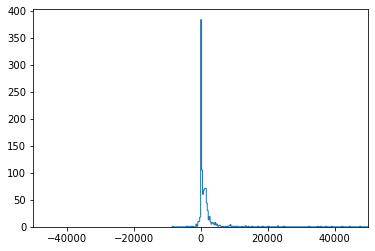

In [5]:
#View distribution of invoice values
plt.hist(df['DEB_CRE_USD'],bins='auto', histtype='step')
plt.xlim(-50000,50000)

#Most invoices fall within a relatively small range. To consider removing outliers.

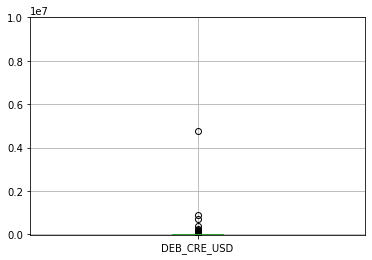

In [6]:
axes = df.boxplot(column=['DEB_CRE_USD'], return_type='axes')
axes.set_ylim(-25000,10000000)
plt.show()

In [7]:
modelVals = FeatureEngine(df)

#One hot encodes various categorical fields
modelVals.oneHotEncodeLabels(["REF_KEY1","PROFIT_CTR","AC_DOC_TYP","POST_KEY","GL_ACCOUNT","ZTCODE", "BIC_ZTERMPAY", "MATL_GROUP", "ACCNT_GRPV"])

#overwrite features to retain after the dfscaled df is called.
modelVals.df['invoiceval'] = modelVals.df['DEB_CRE_USD']
modelVals.df['vendorCount'] = modelVals.df['TransCount']
modelVals.df['HCPWord'] = modelVals.df['TriggerWord']

#Vectorizes common words in the model.
#In addition to frequent words we should also specifically get words or phrases that are specific to HCP selections.To also evaluate if we should use TD-IDF vs. standard count vectorizer
#modelVals.concatVector('textappend',1,2,min_df=0.20,max_df=0.90) 





modelVals.df

,COMP_CODE,REF_KEY1,AC_DOC_NR,PSTNG_DATE,CREATEDON,DOC_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,CREDITOR,...,MATL_GROUP_Z1-102130,MATL_GROUP_Z1-134170,MATL_GROUP_Z1-182198,MATL_GROUP_nan_MATL_GROUP,ACCNT_GRPV_Z001,ACCNT_GRPV_Z003,ACCNT_GRPV_Z004,invoiceval,vendorCount,HCPWord
0,1003,nan_REF_KEY1,5000182043,2019-09-30,2019-09-30,2019-09-30,12262,WE,81,10027697,...,0,0,0,1,1,0,0,13445.19,1,0.0
1,1003,EDIINV,5100010932,2020-01-17,2020-01-17,2020-01-16,12259,RE,81,10003556,...,0,0,0,1,1,0,0,1919.60,154,0.0
2,1003,nan_REF_KEY1,5000071281,2020-04-16,2020-04-16,2020-04-16,12071,WE,81,10033062,...,0,0,0,0,1,0,0,348.00,26,0.0
3,1003,UPLOAD,1900086719,2019-12-30,2019-12-30,2019-10-03,12250,KR,40,30013196,...,0,0,0,1,0,1,0,187.71,1,0.0
4,1003,EDIINV,5100182522,2019-09-13,2019-09-13,2019-09-12,12250,RE,81,10030946,...,0,0,0,1,1,0,0,1115.28,106,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1003,nan_REF_KEY1,5000150718,2019-08-08,2019-08-08,2019-08-08,12071,WE,81,10009414,...,0,0,0,0,1,0,0,980.00,15,0.0
1016,1003,EDIINV,5100006439,2020-01-11,2020-01-11,2020-01-09,12082,RE,81,10003556,...,0,0,0,1,1,0,0,969.36,154,0.0
1017,1003,OCRINV,5100190885,2019-09-26,2019-09-26,2019-09-25,12250,RE,40,30086991,...,0,0,0,1,0,1,0,112.00,2,0.0
1018,1003,OCRINV,5100110476,2019-06-05,2019-06-05,2019-06-03,12071,RE,40,10002390,...,0,0,0,1,1,0,0,6.20,24,0.0


In [8]:
#Output features excludes non-features engineered fields and adds the dfscaled property to the object
modelVals.outputFeatures()

#fit_transform method minmaxscales the dfscaled dataset
modelVals.fit_transform()

dftrain = modelVals.dfscaled

dftrain.to_csv(pathBase + "\Datasets\csvoutput.csv")
dftrain


,ACCNT_GRPV_Z001,ACCNT_GRPV_Z003,ACCNT_GRPV_Z004,AC_DOC_TYP_KR,AC_DOC_TYP_RE,AC_DOC_TYP_WE,HCPWord,MATL_GROUP_124070,MATL_GROUP_124099,MATL_GROUP_152010,...,ZTCODE_MBST,ZTCODE_MIGO_GR,ZTCODE_MIRO,ZTCODE_MR1M,ZTCODE_MR8M,ZTCODE_VL09,ZTCODE_VL32N,ZTCODE_ZFII_INV_UPD_PGM,invoiceval,vendorCount
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004622,0.000000
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.002197,1.000000
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001867,0.163399
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001833,0.000000
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.002028,0.686275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002000,0.091503
1016,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.001998,1.000000
1017,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.001817,0.006536
1018,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.001795,0.150327


In [9]:
#Convert pandas df to numpy format and confirm appropriate format to feed into models. 
#Shape should be in the form of (rows count,fields count)

dftrainnumpy = dftrain.to_numpy()
dftrainnumpy.shape


(1020, 56)

In [10]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

#Defined permutations
tuned = {'n_estimators':[50,100,150,200], 'max_samples':['auto'],'contamination':['auto'], 'max_features':[1,.95,0.85, 0.75, 0.50],
        'bootstrap':[False],'random_state':[None], 'verbose':[1], 'warm_start':[True], 'random_state':[12345]}  

#The mean of the score_examples method is utilized to determine the best model. 
def scorer_f(estimator, X):   #your own scorer
      return np.mean(estimator.score_samples(X))

isolation_forest = GridSearchCV(IsolationForest(), tuned, scoring=scorer_f)
model = isolation_forest.fit(dftrainnumpy)

#Outputs the paramaters for the model that performed the best
isolation_forest.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

IsolationForest(max_features=0.85, n_estimators=50, random_state=12345,
                verbose=1, warm_start=True)

In [10]:
from sklearn.ensemble import IsolationForest


dfresults = modelVals.df[modelVals.originalFeatures]
seed = 12345
ntrees = 100
model = IsolationForest(random_state=seed, n_estimators=ntrees, warm_start=True, max_features=.85)
model.fit(dftrainnumpy)

dfresults['scores'] = model.decision_function(dftrainnumpy)
dfresults['anomaly'] = model.predict(dftrainnumpy)


#reduce to 2 dimensional space with PCA and graph results to identify if anomolies are properly being captured
df['scores'] = dfresults['scores']
df['anomaly'] = dfresults['anomaly']
dfresults.to_csv(pathBase + "\Datasets\IFresults.csv")
df

#Feature ** 2 <= rows

,COMP_CODE,REF_KEY1,AC_DOC_NR,PSTNG_DATE,CREATEDON,DOC_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,CREDITOR,...,DEB_CRE_USD,BIC_ZTERMPAY,MATL_GROUP,ACCNT_GRPV,BIC_ZUSERNAM_BINARY,TransCount,TriggerWord,textappend,scores,anomaly
0,1003,nan_REF_KEY1,5000182043,2019-09-30,2019-09-30,2019-09-30,12262,WE,81,10027697,...,13445.19,24,nan_MATL_GROUP,Z001,SYSTEM,1,0.0,MERGON INTERNATIONAL 2L ALINITY BTLE VALIDATIO...,0.105216,1
1,1003,EDIINV,5100010932,2020-01-17,2020-01-17,2020-01-16,12259,RE,81,10003556,...,1919.60,23,nan_MATL_GROUP,Z001,SYSTEM,154,0.0,"EXPERIS US, INC. nan nan",0.141100,1
2,1003,nan_REF_KEY1,5000071281,2020-04-16,2020-04-16,2020-04-16,12071,WE,81,10033062,...,348.00,23,Z1-102126,Z001,USER,26,0.0,SERACARE LIFE SCIENCES INC nan nan,0.100452,1
3,1003,UPLOAD,1900086719,2019-12-30,2019-12-30,2019-10-03,12250,KR,40,30013196,...,187.71,23,nan_MATL_GROUP,Z003,USER,1,0.0,RED WING SHOE STORE nan 2.02E+13,-0.067391,-1
4,1003,EDIINV,5100182522,2019-09-13,2019-09-13,2019-09-12,12250,RE,81,10030946,...,1115.28,23,nan_MATL_GROUP,Z001,SYSTEM,106,0.0,HIREGENICS INC nan nan,0.151230,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1003,nan_REF_KEY1,5000150718,2019-08-08,2019-08-08,2019-08-08,12071,WE,81,10009414,...,980.00,13,Z1-102110,Z001,USER,15,0.0,MICROGENICS CORPORATION nan nan,0.051699,1
1016,1003,EDIINV,5100006439,2020-01-11,2020-01-11,2020-01-09,12082,RE,81,10003556,...,969.36,23,nan_MATL_GROUP,Z001,SYSTEM,154,0.0,"EXPERIS US, INC. nan nan",0.140778,1
1017,1003,OCRINV,5100190885,2019-09-26,2019-09-26,2019-09-25,12250,RE,40,30086991,...,112.00,23,nan_MATL_GROUP,Z003,USER,2,0.0,LIFE TECHNOLOGIES CORPORATION nan nan,0.005697,1
1018,1003,OCRINV,5100110476,2019-06-05,2019-06-05,2019-06-03,12071,RE,40,10002390,...,6.20,24,nan_MATL_GROUP,Z001,USER,24,0.0,MAINE STANDARDS COMPANY LLC nan nan,0.033040,1


[0.4974345  0.13966288]


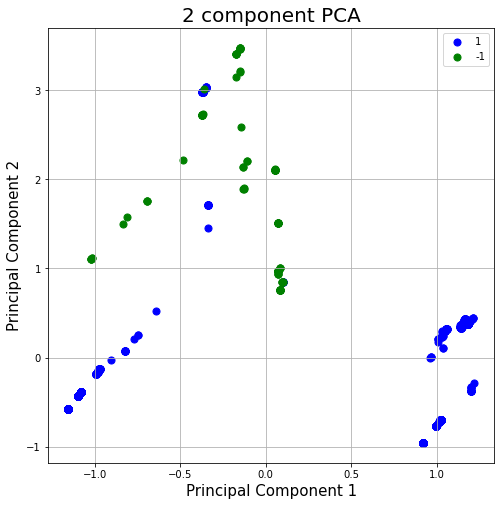

In [11]:
#Utilize PCA to reduce high # of dimensions into 2
pca2d = PCA(n_components=2, whiten=True)
principalComponents2d = pca2d.fit_transform(dftrain)
principalDf2d = pd.DataFrame(data = principalComponents2d, columns = ['principal component 1', 'principal component 2'])
finalDf2d = pd.concat([principalDf2d, df[['anomaly']]], axis = 1)


#Plot reduced dimensions based upon labeled values to validate that the anomoly classification appears reasonable
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, -1]
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf2d['anomaly'] == target
    ax.scatter(finalDf2d.loc[indicesToKeep, 'principal component 1']
               , finalDf2d.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

print(pca2d.explained_variance_ratio_)


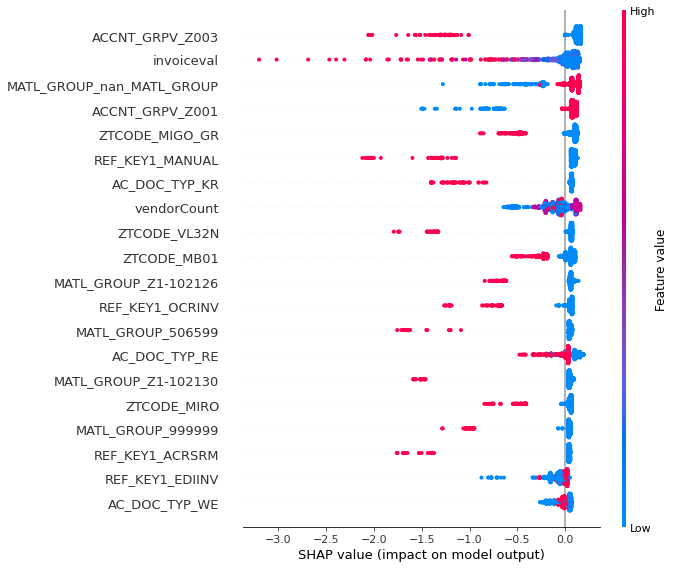

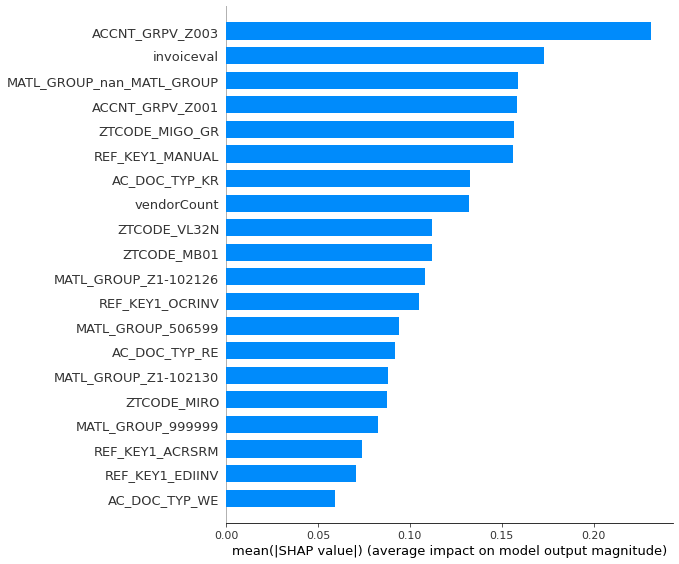

,ACCNT_GRPV_Z001,ACCNT_GRPV_Z003,ACCNT_GRPV_Z004,AC_DOC_TYP_KR,AC_DOC_TYP_RE,AC_DOC_TYP_WE,HCPWord,MATL_GROUP_124070,MATL_GROUP_124099,MATL_GROUP_152010,...,ZTCODE_MBST,ZTCODE_MIGO_GR,ZTCODE_MIRO,ZTCODE_MR1M,ZTCODE_MR8M,ZTCODE_VL09,ZTCODE_VL32N,ZTCODE_ZFII_INV_UPD_PGM,invoiceval,vendorCount
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004622,0.000000
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.002197,1.000000
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001867,0.163399
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001833,0.000000
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.002028,0.686275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002000,0.091503
1016,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.001998,1.000000
1017,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.001817,0.006536
1018,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.001795,0.150327


In [12]:
#Graph feature importance
import shap
X_explain = dftrainnumpy
shap_values = shap.TreeExplainer(model).shap_values(dftrain)
shap.summary_plot(shap_values, dftrain)
shap.summary_plot(shap_values, dftrain, plot_type="bar")
dftrain


#Note: Once we get HCP and full datasets we can permutate different combinations of features to determine which combination of features reasults in the most # of selections of HCP transacations
#Note: For Government transactions we can attempt to optimize by:
#(1) Permutating features and checking which # of features results in the highest number of Government records based off of a regex analysis.
#(2) Feature combination with the 